In [2]:

import os
# Replace this path with the path to your dataset folder
filename = "C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\HAM10000"
# List the files in the dataset folder
file_list = os.listdir(filename)
# Print the list of files as a check
print("Files in the dataset folder:", file_list)

Files in the dataset folder: ['HAM10000_metadata.csv', 'hmnist_8_8_L.csv', 'ISIC_0024306.jpg', 'ISIC_0024307.jpg', 'ISIC_0024308.jpg', 'ISIC_0024309.jpg', 'ISIC_0024310.jpg', 'ISIC_0024311.jpg', 'ISIC_0024312.jpg', 'ISIC_0024313.jpg', 'ISIC_0024314.jpg', 'ISIC_0024315.jpg', 'ISIC_0024316.jpg', 'ISIC_0024317.jpg', 'ISIC_0024318.jpg', 'ISIC_0024319.jpg', 'ISIC_0024320.jpg', 'ISIC_0024321.jpg', 'ISIC_0024322.jpg', 'ISIC_0024323.jpg', 'ISIC_0024324.jpg', 'ISIC_0024325.jpg', 'ISIC_0024326.jpg', 'ISIC_0024327.jpg', 'ISIC_0024328.jpg', 'ISIC_0024329.jpg', 'ISIC_0024330.jpg', 'ISIC_0024331.jpg', 'ISIC_0024332.jpg', 'ISIC_0024333.jpg', 'ISIC_0024334.jpg', 'ISIC_0024335.jpg', 'ISIC_0024336.jpg', 'ISIC_0024337.jpg', 'ISIC_0024338.jpg', 'ISIC_0024339.jpg', 'ISIC_0024340.jpg', 'ISIC_0024341.jpg', 'ISIC_0024342.jpg', 'ISIC_0024343.jpg', 'ISIC_0024344.jpg', 'ISIC_0024345.jpg', 'ISIC_0024346.jpg', 'ISIC_0024347.jpg', 'ISIC_0024348.jpg', 'ISIC_0024349.jpg', 'ISIC_0024350.jpg', 'ISIC_0024351.jpg', 'ISIC

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
data_pd = pd.read_csv('C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\HAM10000\\HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [6]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [7]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [8]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [9]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [10]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [11]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [12]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [13]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
3876,HAM_0000027,ISIC_0030509,nv,follow_up,75.0,female,trunk,no
9965,HAM_0001302,ISIC_0032206,akiec,histo,50.0,male,neck,no
2995,HAM_0002971,ISIC_0026425,nv,follow_up,45.0,female,lower extremity,no
3774,HAM_0003630,ISIC_0030538,nv,follow_up,65.0,female,upper extremity,no
6185,HAM_0000938,ISIC_0031916,nv,follow_up,40.0,female,foot,no


In [14]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [15]:
len(test_list)

828

In [16]:
len(train_list)

9187

In [17]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [18]:
#train_dir = os.getcwd()
import os

# Example directory paths
base_dir = "C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000"
train_dir15 = os.path.join(base_dir, "train_dir15")
test_dir15 = os.path.join(base_dir, "test_dir15")

# Create the parent directories if they don't exist
os.makedirs(train_dir15, exist_ok=True)
os.makedirs(test_dir15, exist_ok=True)



In [19]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [20]:
for i in targetnames:
  directory1=train_dir15+'/'+i
  directory2=test_dir15+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [21]:

import os
import shutil

for image in train_list:
    source_dir = r"C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\HAM10000"
    train_dir = r"C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\train_dir15"

    # getting the file name and label
    file_name = image+".jpg"
    label = data_pd.loc[image, 'dx']
    # creating the source and target paths using os.path.join
    source = os.path.join(source_dir, file_name)
    target = os.path.join(train_dir, label, file_name)

    # copying the file from the source to the target folder
    shutil.copyfile(source, target)
   


In [22]:

import os
import shutil

for image in test_list:
    source_dir = r"C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\HAM10000"
    test_dir = r"C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\test_dir15"

    # getting the file name and label
    file_name = image+".jpg"
    label = data_pd.loc[image, 'dx']

    # creating the source and target paths using os.path.join
    source = os.path.join(source_dir, file_name)
    target = os.path.join(test_dir, label, file_name)

    # copying the file from the source to the target folder
    shutil.copyfile(source, target)

In [23]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir1 = 'aug_dir1'
    os.mkdir(aug_dir1)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir1, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\train_dir15\\' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\train_dir15\\' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir1

    # Augmented images will be saved to training directory
    save_path = 'C:\\Users\\RTX3060\\Desktop\\paper1\\HAM-10000\\train_dir15\\' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        rescale=1./255

   
    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir1')



Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [24]:
train_path = 'C:/Users/RTX3060/Desktop/paper1/HAM-10000/train_dir15/'
test_path = 'C:/Users/RTX3060/Desktop/paper1/HAM-10000/test_dir15/'
batch_size = 16

In [25]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [26]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [30]:
from tensorflow.keras.layers import Layer, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Activation
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint, EarlyStopping 

class ChannelAttention(Layer):
    def __init__(self, in_channels, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)  # Pass extra arguments to the Layer base class
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()
        self.fc1 = Dense(in_channels // reduction_ratio, activation='relu', use_bias=False)
        self.fc2 = Dense(in_channels, use_bias=False)
        self.sigmoid = Activation('sigmoid')

    def call(self, inputs):
        avg_pooled = self.avg_pool(inputs)
        max_pooled = self.max_pool(inputs)
        avg_pooled = Reshape((1, 1, avg_pooled.shape[-1]))(avg_pooled)
        max_pooled = Reshape((1, 1, max_pooled.shape[-1]))(max_pooled)
        out = self.fc1(avg_pooled + max_pooled)
        out = self.fc2(out)
        scale = self.sigmoid(out)
        return inputs * scale

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)  # Pass extra arguments to the Layer base class
        self.conv = Conv2D(1, kernel_size, padding='same', use_bias=False, activation='sigmoid')

    def call(self, inputs):
        max_out = tf.reduce_max(inputs, axis=3, keepdims=True)
        avg_out = tf.reduce_mean(inputs, axis=3, keepdims=True)
        out = tf.concat([max_out, avg_out], axis=3)
        out = self.conv(out)
        return inputs * out






# Load InceptionResNetV2 without the top layer
irv2 = tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=None, pooling=None)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-26].output

channel_attention = ChannelAttention(in_channels=int(conv.shape[-1]), name='channel_attention')(conv)
spatial_attention = SpatialAttention(name='spatial_attention')(channel_attention)


pooled_attention = GlobalAveragePooling2D()(spatial_attention)
pooled_conv = GlobalAveragePooling2D()(conv)

# Since GlobalAveragePooling2D outputs 2D, we expand dimensions to use SpatialDropout2D
pooled_attention = tf.expand_dims(tf.expand_dims(pooled_attention, 1), 1)
pooled_conv = tf.expand_dims(tf.expand_dims(pooled_conv, 1), 1)

# Concatenate pooled outputs
concatenated = Concatenate()([pooled_attention, pooled_conv])

# Normalization and Activation
conv = LayerNormalization()(concatenated)
conv = Activation('relu')(conv)
conv = SpatialDropout2D(0.5)(conv)  # Now it should be compatible as conv is 4D

# Flatten for output layer since it's fully connected
conv = Flatten()(conv)


output = Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv)

# Create the model
model = Model(inputs=irv2.input, outputs=output)

# Model summary
model.summary()




 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_609 (Conv2D)            (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_609 (Batch  (None, None, None,   96         ['conv2d_609[0][0]']             
 Normalization)                 32)                                                           

Soft Attention

In [31]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [32]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath ='IRv2==CBAM2.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [33]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=15, min_delta=0.001,restore_best_weights=True)
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=290,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/290
918/918 - 397s - loss: 1.9461 - accuracy: 0.4729 - val_loss: 0.9166 - val_accuracy: 0.7319 - 397s/epoch - 432ms/step
Epoch 2/290
918/918 - 366s - loss: 1.1654 - accuracy: 0.6971 - val_loss: 0.4921 - val_accuracy: 0.8720 - 366s/epoch - 398ms/step
Epoch 3/290
918/918 - 365s - loss: 0.8840 - accuracy: 0.7786 - val_loss: 0.3746 - val_accuracy: 0.9022 - 365s/epoch - 397ms/step
Epoch 4/290
918/918 - 363s - loss: 0.7158 - accuracy: 0.8178 - val_loss: 0.4191 - val_accuracy: 0.8901 - 363s/epoch - 395ms/step
Epoch 5/290
918/918 - 364s - loss: 0.5758 - accuracy: 0.8634 - val_loss: 0.3480 - val_accuracy: 0.9094 - 364s/epoch - 397ms/step
Epoch 6/290
918/918 - 364s - loss: 0.4982 - accuracy: 0.8838 - val_loss: 0.2895 - val_accuracy: 0.9191 - 364s/epoch - 397ms/step
Epoch 7/290
918/918 - 364s - loss: 0.4372 - accuracy: 0.8974 - val_loss: 0.3483 - val_accuracy: 0.9094 - 364s/epoch - 396ms/step
Epoch 8/290
918/918 - 364s - loss: 0.3660 - accuracy: 0.9169 - val_loss: 0.3623 - val_accuracy: 0

In [34]:
from tensorflow.keras import models
model.load_weights("IRv2==CBAM2.hdf5")

In [35]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [36]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.89      0.74      0.81        23
         bcc       0.92      0.88      0.90        26
         bkl       0.85      0.77      0.81        66
          df       1.00      0.67      0.80         6
         mel       0.67      0.82      0.74        34
          nv       0.97      0.98      0.98       663
        vasc       1.00      1.00      1.00        10

    accuracy                           0.95       828
   macro avg       0.90      0.84      0.86       828
weighted avg       0.95      0.95      0.95       828



In [37]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.948542100898635
Recall: 0.9468599033816425
Accuracy: 0.9468599033816425
weighted Roc score: 0.9900260669527258


In [38]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.9008506295679319
Recall: 0.8383670890064752
Accuracy: 0.9468599033816425
Macro Roc score: 0.990215897050998


In [39]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9468599033816425
Recall: 0.9468599033816425
Accuracy: 0.9468599033816425
Micro Roc score: 0.9960629672415536


In [40]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9918444504455847
The ROC AUC score of bcc is: 0.9872434298868215
The ROC AUC score of bkl is: 0.9808518253400142
The ROC AUC score of df is: 0.9985806974858069
The ROC AUC score of mel is: 0.9818121203141206
The ROC AUC score of nv is: 0.9911787558846383
The ROC AUC score of vasc is: 1.0


In [41]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

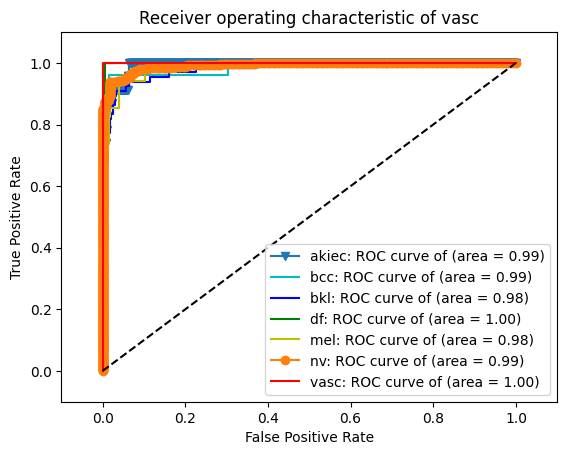

In [42]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

In [45]:
x_test,y_test=next(test_batches)

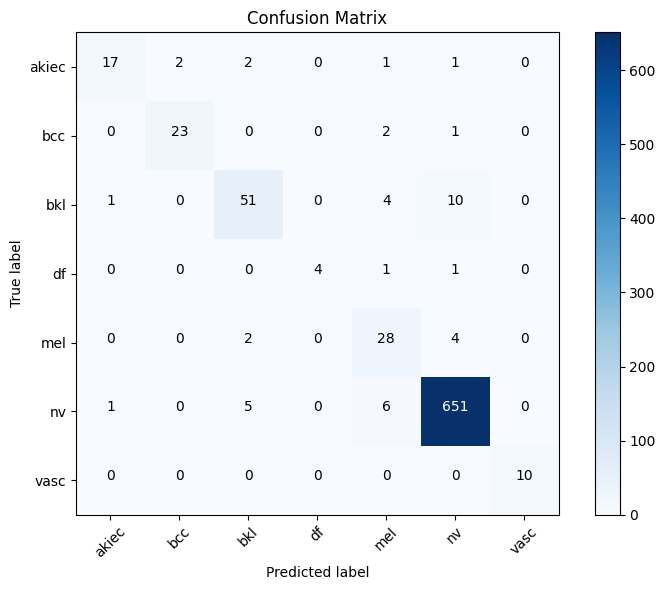

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined correctly
# y_true = test_batches.classes  # Ensure this is correctly fetching the labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(targetnames))
plt.xticks(tick_marks, targetnames, rotation=45)
plt.yticks(tick_marks, targetnames)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()